In [ ]:
# imports
%matplotlib inline
import matplotlib.pyplot as plt
import random
import numpy as np
import tensorflow as tf
from sklearn.neighbors import KNeighborsClassifier as KNC
import time

## **$\color{darkorange}{\text{MNIST dataset}}$** 

Loading the MNIST dataset and inspect it.

In [ ]:
mnist = tf.keras.datasets.mnist
(train_data,train_labels),(test_data,test_labels) = mnist.load_data()

print("Number of training examples\t",len(train_data))
print("Number of test instances\t",len(test_data))
print("Shape of train_data\t\t",train_data.shape)
print("Shape of train_labels\t\t",train_labels.shape)
print("Shape of test_data\t\t",test_data.shape)
print("Shape of test_labels\t\t",test_labels.shape)

11493376/11490434 [==============================] - 0s 0us/step
Number of training examples	 60000
Number of test instances	 10000
Shape of train_data		 (60000, 28, 28)
Shape of train_labels		 (60000,)
Shape of test_data		 (10000, 28, 28)
Shape of test_labels		 (10000,)


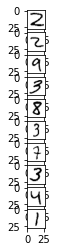

In [ ]:
# Randomly choose 10 images from first 1000 images of Train Data
for index,idx in enumerate(random.sample(range(1000),10)): 
    plt.subplot(10,1,index+1)
    plt.imshow(train_data[idx],cmap="Greys")

In [ ]:
# Flatten the train_data and test_data for faster computation
train_data = train_data.reshape([60000,784])
test_data = test_data.reshape([10000,784])

# Convertting the int8 datatype to float/int 32/64
train_data = np.float32(train_data)
test_data = np.float32(test_data)

## **$\color{darkorange}{\text{KNN Classifier}}$** 


General Hint: 
* Initially don't try to do any extra optimization: start by just getting the basic kNN algorithm to work.
* Try as simple a version as you can:
   * can you try it for a small set of low-dimensional points?
   * can you try it for a tiny set (e.g. 3 or 4) of MNIST images?

* Once you've got the basics working for a tiny data set, compute the Euclidean Distance more efficiently by using:
$$|| x - y||_2 = x.x^T -2x.y + y.y^T$$

In [ ]:
# custom KNN class
from scipy.spatial.distance import cdist
class KNN:
    def __init__(self, k , num_classes):
        self.num_classes = num_classes
        self.k = k
        self.parameters = None
    
    # finds the distance between points from test data ans training data
    def distance_batch(self,data):# M x 784; N x 784
        train_data = self.parameters[0]
        return cdist(data,train_data)
    
    # Trains the classifier using the training data and training labels.
    def train(self, training_data, training_labels):
        self.parameters = [training_data, training_labels]

    # Makes use of the trained parameters to predict the class and returns the most probable class.
    # Calls the predict_proba method.    
    def predict(self, data):
        all_probabilities = self.predict_proba(data)
        predicted_labeles = np.zeros(len(all_probabilities))
        for index, i in enumerate(all_probabilities):
            predicted_labeles[index] = np.argmax(i)           
        return predicted_labeles
    
    #  For each data point, predicts the assigned class probabilities.
    def predict_proba(self,data):
        distance_output = self.distance_batch(data)
        sorted_distance_index = np.argpartition(distance_output,self.k)
  
        predict_mat = np.zeros(shape = (len(sorted_distance_index),10))
        for index, i in enumerate(sorted_distance_index):
            for j in i[:self.k]:
                current_label = self.parameters[1][j]
                predict_mat[index][current_label] += 1/self.k
        return predict_mat

    #  Returns the accuracy as a percentage computed over the data.  
    def accuracy(self, data, labels):
        num_correct = 0
        num_seen = 0
        pred_labels = np.array(self.predict(data))
        return (pred_labels==labels).sum()/len(data)

## **$\color{darkorange}{\text{Evaluation!}}$** 
Let's instatiate our KNN and the KNN provided by SkLearn. 

In [ ]:
custom_knn = KNN(k=5,num_classes=10)
custom_knn.train(train_data,train_labels)

sklearn_knn = KNC(5,algorithm="brute")
sklearn_knn.fit(train_data,train_labels)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

First, we will check the accuracy <u>on first 100</u> examples of test dataset.

In [ ]:
t=time.clock()
print("Custom KNN Accuracy:\t",custom_knn.accuracy(test_data[:100],test_labels[:100]))
print("Time taken:\t\t",time.clock()-t,"\n")

t=time.clock()
print("SkLearn KNN Accuracy:\t",(sklearn_knn.predict(test_data[:100])==test_labels[:100]).sum()/100)
print("Time taken:\t\t",time.clock()-t)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


Custom KNN Accuracy:	 0.99
Time taken:		 3.9814969999999974 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """


SkLearn KNN Accuracy:	 0.99
Time taken:		 1.1882259999999967


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  import sys


To check correctness, we will sample 200 examples from the test dataset and compare the predict_proba methods.

In [ ]:
indices = random.sample(range(len(test_data)),200)
selected_data = test_data[indices]
selected_labels = test_labels[indices]
print((np.abs(custom_knn.predict_proba(selected_data)-sklearn_knn.predict_proba(selected_data))<10**-10).all())

True


The difference between predections by our KNN and SkLearn's KNN is lower than $10^{-10}$, that's great! 

## **$\color{darkorange}{\text{Cross-validation to choose k}}$** 

Now, I use SkLearn to perform <b>10-fold cross-validation</b> across different values of k (the KNN hyperparameter) [1,5,10,15,20]. Then, I plot the graph of test accuracy (along with standard-deviation) for each value of k. This would answer twoi questions:
* What is the ideal value of k according to our experiments?
* How do we decide?



In [ ]:
"""
Generates a graph of test-accuracy along with standard deviation
as a function of the ks.
"""
def kNN_CrossVal(data,labels,ks=[1,5,10,15,20]):
    from sklearn.model_selection import cross_val_score
    import statistics
    from statistics import mean

    y = []
    std_accurayy = []
    for k in ks:
        knn = KNC(n_neighbors=k)
        test_accuracy = cross_val_score(knn, data, labels, cv=10, scoring='accuracy')
        std_accurayy.append(statistics.stdev(test_accuracy))
        y.append(mean(test_accuracy))
    plt.figure()
    plt.xlabel('Number of Neighbors (K)')
    plt.ylabel('test_accuracy')
    plt.xticks(ks)  
    plt.errorbar(ks, y, yerr = std_accurayy,fmt='o')
        

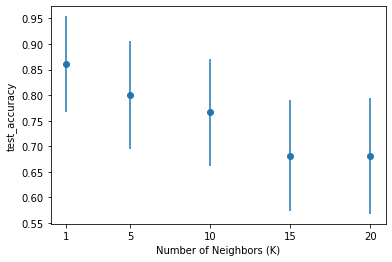

In [ ]:
kNN_CrossVal(train_data[0:201,:],train_labels[0:201])

Take away lesson: the larger <code>k</code>, the lower accuracy is. But, at the same time, the amount of variation of the accuracy is higher.

## **$\color{darkorange}{\text{Analyzing performance on MNIST}}$** 


Now, I analyze the images which got misclassified by KNN (with k = 5) by showing in detail the Nearest Neighbors. 

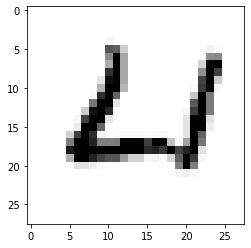

The Nearest Neighbor label is: 0.0
***********************************


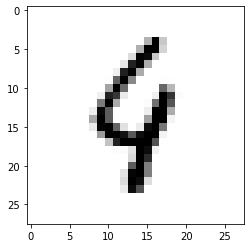

The Nearest Neighbor label is: 9.0
***********************************


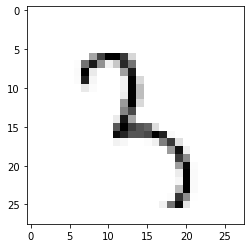

The Nearest Neighbor label is: 1.0
***********************************


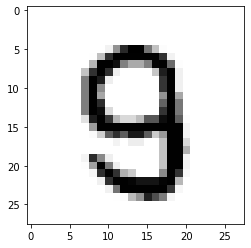

The Nearest Neighbor label is: 8.0
***********************************


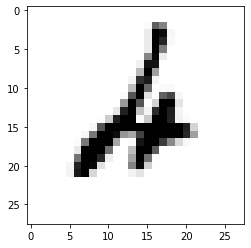

The Nearest Neighbor label is: 6.0
***********************************


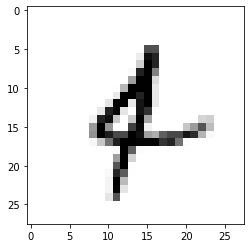

The Nearest Neighbor label is: 1.0
***********************************


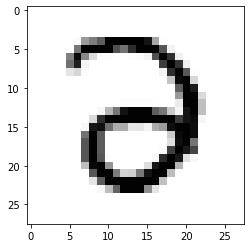

The Nearest Neighbor label is: 0.0
***********************************


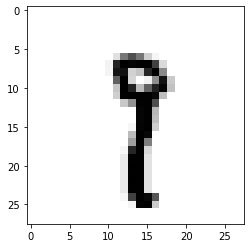

The Nearest Neighbor label is: 7.0
***********************************


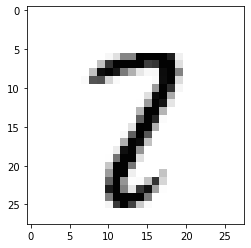

The Nearest Neighbor label is: 7.0
***********************************


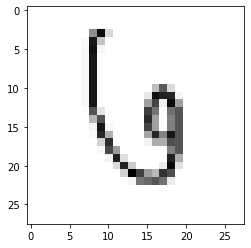

The Nearest Neighbor label is: 4.0
***********************************


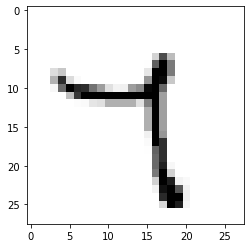

The Nearest Neighbor label is: 4.0
***********************************


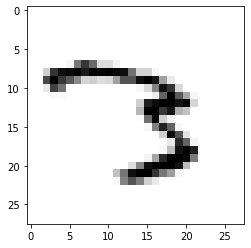

The Nearest Neighbor label is: 7.0
***********************************


In [ ]:
# Code here. 
predictions = custom_knn.predict(test_data[0:401,:])
for index , image in enumerate(test_data[0:401,:]):
    if predictions[index] != test_labels[0:401][index]:
        plt.imshow(test_data[0:401,:][index].reshape(28,28),cmap = "Greys")
        plt.show()
        print('The Nearest Neighbor label is:' ,predictions[index])
        print("*"*35)
    else:
        continue
